In [3]:
# Run this to load the MNIST dataset
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
import seaborn as sns
from sklearn.metrics import confusion_matrix


X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

In [2]:
# Check the shape of the data to reshape it accordingly
size = X.shape # Check the shape of the data
print(size)

(70000, 784)


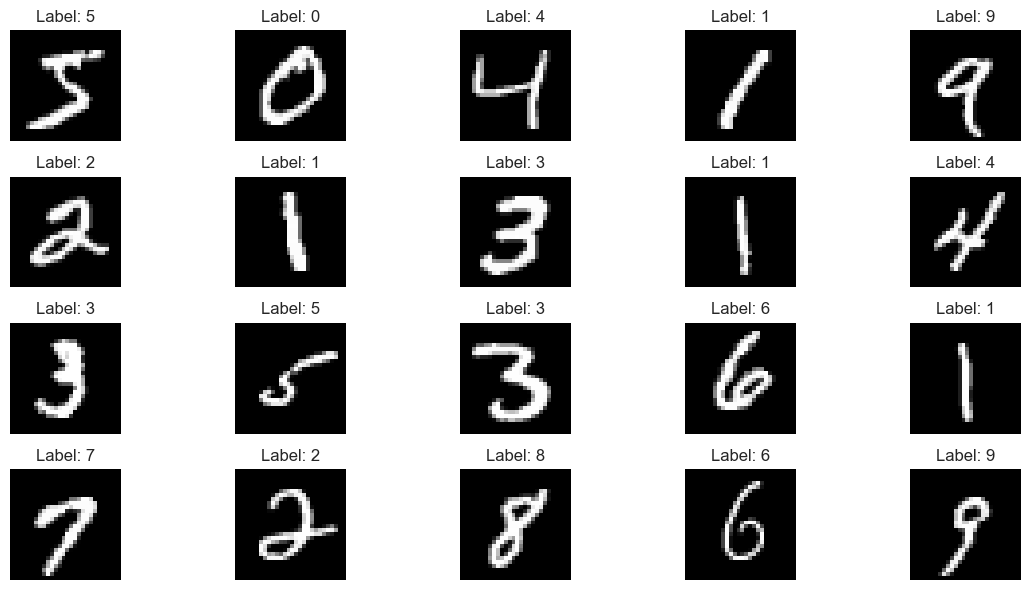

In [3]:
# Reshape the data
X_images = X.reshape(-1, 28, 28)  # Each digit is 28x28 pixels

# Plot the first 20 digits with their labels
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Label: {y[i]}')
plt.tight_layout()
plt.show()

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train a logistic regression model
log_reg_no_tuning = LogisticRegression(max_iter=750, tol=1e-1, random_state=42)
log_reg_no_tuning.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=750, random_state=42, tol=0.1)

In [6]:
# Define parameter grid
param_grid = [
    {'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1,0.2, 0.3],
     'solver': ['saga'],
     'max_iter': [750, 1000, 1200]},
]

# Setup GridSearchCV
log_reg = LogisticRegression(tol=1e-1, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 0.2, 'max_iter': 750, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.879357142857143


In [6]:
# Train a logistic regression model with the best parameters
log_reg = LogisticRegression(penalty='l1', solver='saga', C=0.2, max_iter=750, tol=1e-1,random_state=42, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.2, max_iter=750, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga', tol=0.1)

In [10]:
# Predict on the test set without tuning
y_pred_no_tuning = log_reg_no_tuning.predict(X_test_scaled)
report_no_tuning = classification_report(y_test, y_pred_no_tuning, output_dict=True)
report_no_tuning_df = pd.DataFrame(report_no_tuning).transpose()

# Predict on the test set with tuning
y_pred = log_reg.predict(X_test_scaled)
report_tuning = classification_report(y_test, y_pred, output_dict=True)
report_tuning_df = pd.DataFrame(report_tuning).transpose()

# Create HTML tables for both reports
html_report_no_tuning = report_no_tuning_df.to_html()
html_report_tuning = report_tuning_df.to_html()

# Display side-by-side using HTML
display(HTML(f"""
<table>
    <tr>
        <td><h3>Without Tuning</h3>{html_report_no_tuning}</td>
        <td><h3>With Tuning</h3>{html_report_tuning}</td>
    </tr>
</table>
"""))

,precision,recall,f1-score,support
0,0.658854,0.941921,0.775360,1343.000000
1,0.556494,0.988125,0.712002,1600.000000
2,0.872285,0.727536,0.793362,1380.000000
3,0.708115,0.755059,0.730834,1433.000000
4,0.893094,0.728958,0.802721,1295.000000
5,0.915129,0.389631,0.546556,1273.000000
6,0.860045,0.818768,0.838899,1396.000000
7,0.743792,0.876913,0.804885,1503.000000
8,0.905512,0.508475,0.651251,1357.000000
9,0.777778,0.601408,0.678316,1420.000000


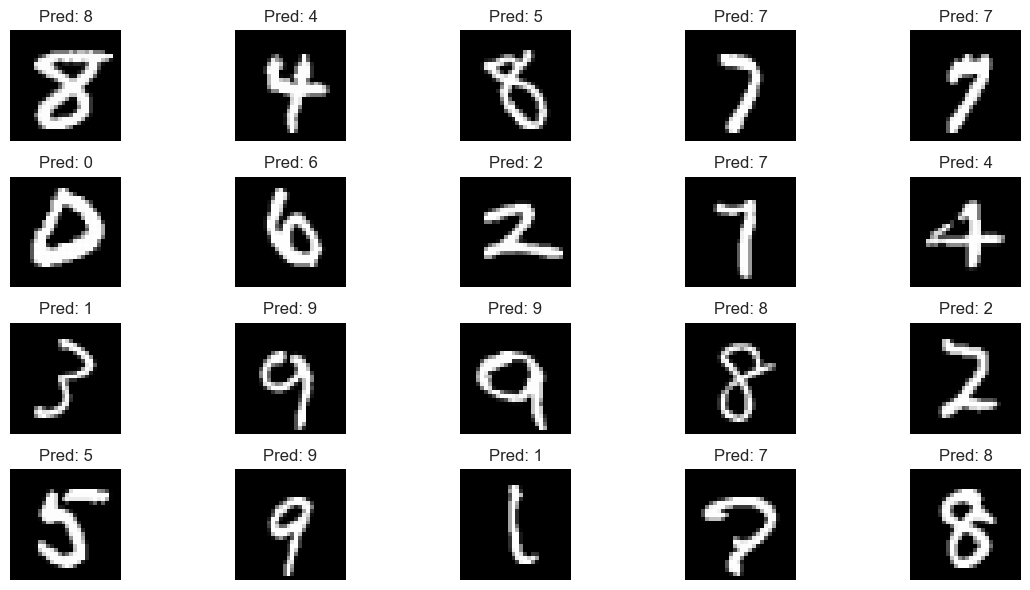

In [11]:
# Plot the first 20 digits with their predicted labels
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Use X_test instead of X_images for correct predictions
    plt.axis('off')
    plt.title(f'Pred: {y_pred[i]}')
plt.tight_layout()
plt.show()

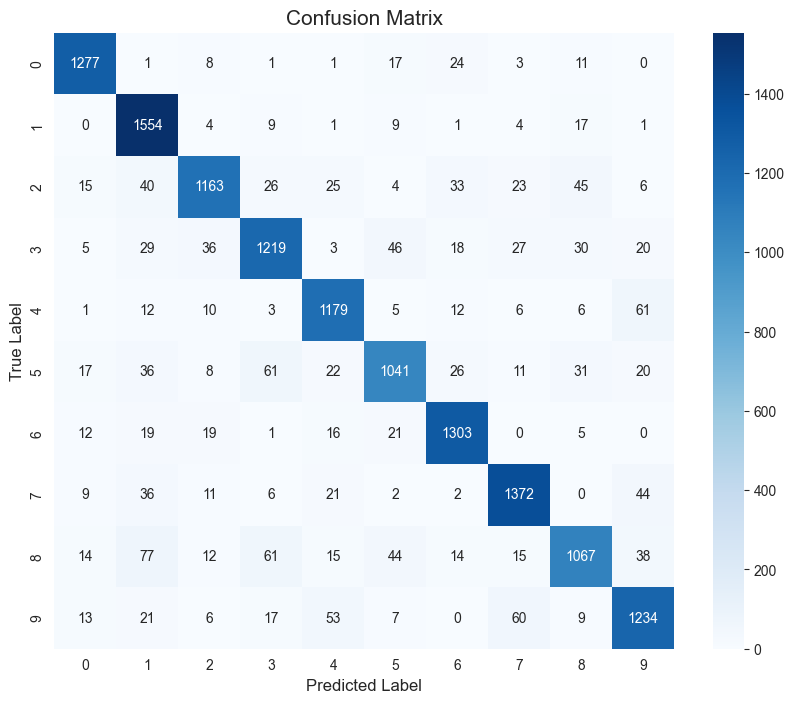

In [12]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.show()

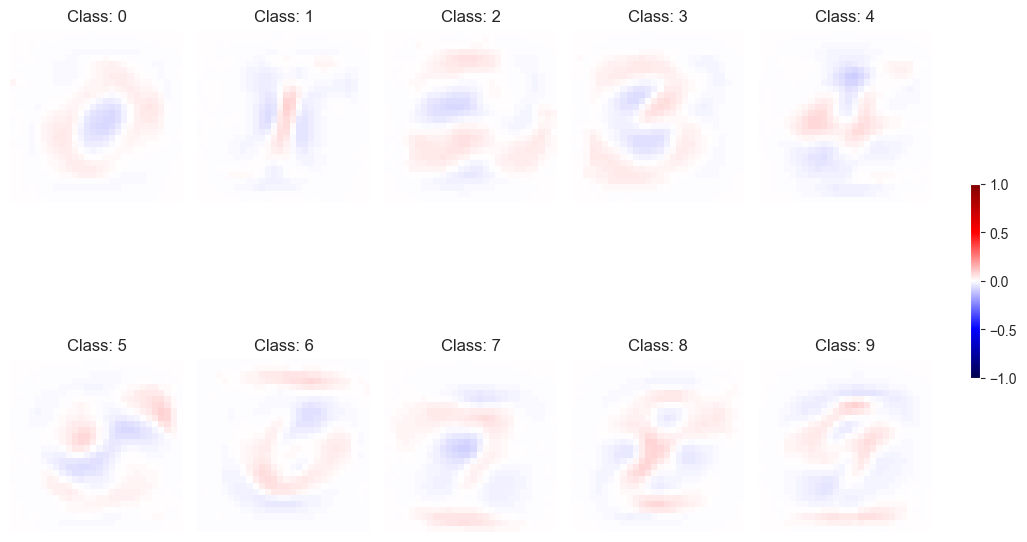

In [13]:
# Get the predicted weights for each class
weights = log_reg.coef_  # Shape will be (10, 784), where 10 is the number of classes

# Plot the classification vectors (weights) for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights[i].reshape(28, 28), cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'Class: {i}')
plt.tight_layout()
plt.colorbar(ax=plt.gcf().axes, fraction=0.01, pad=0.04)
plt.show()

In [14]:
# Apply PCA to the MNIST dataset
pca = PCA()
X_scaled = scaler.fit_transform(X)  # Scale the entire dataset for PCA
pca.fit(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f'Number of components needed to explain 80% of variance: {n_components_80}')

Number of components needed to explain 80% of variance: 150


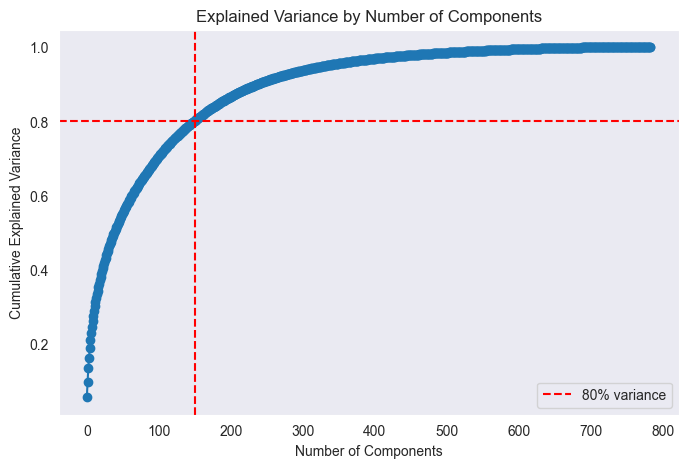

In [15]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
plt.axvline(x=n_components_80, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.legend()
plt.grid()
plt.show()

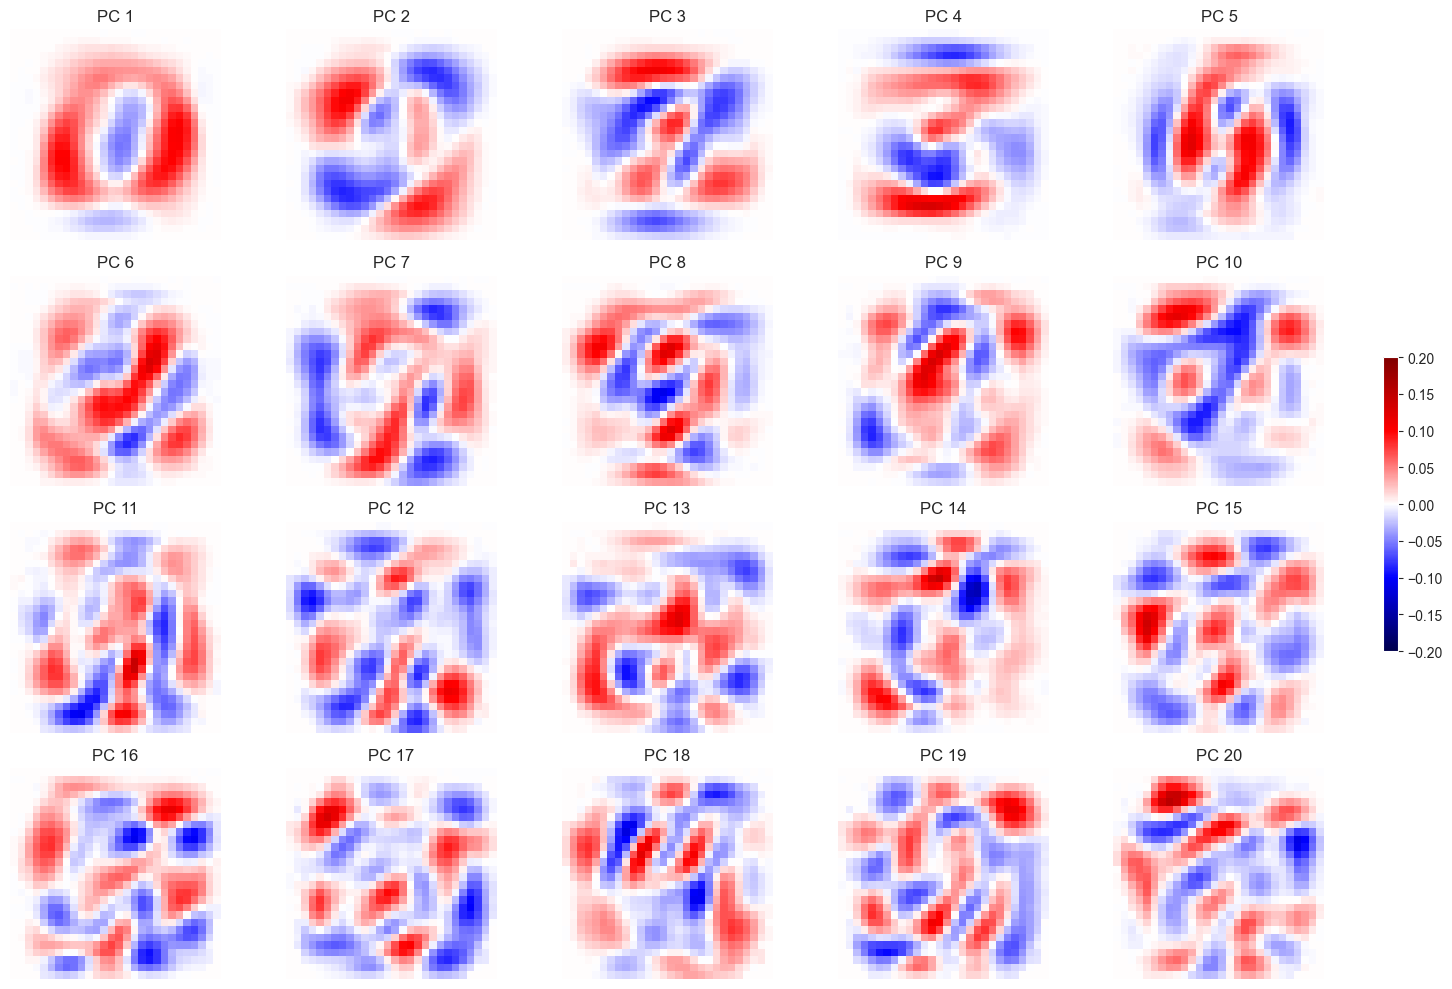

In [16]:
# Fit PCA again with the number of components needed for visualization
pca_20 = PCA(n_components=20)
pca_20.fit(X_scaled)

# Plot the loadings for the first 20 principal components
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pca_20.components_[i].reshape(28, 28), cmap='seismic', vmin=-0.2, vmax=0.2)
    plt.axis('off')
    plt.title(f'PC {i+1}')
plt.tight_layout()
plt.colorbar(ax=plt.gcf().axes, fraction=0.01, pad=0.04)
plt.show()

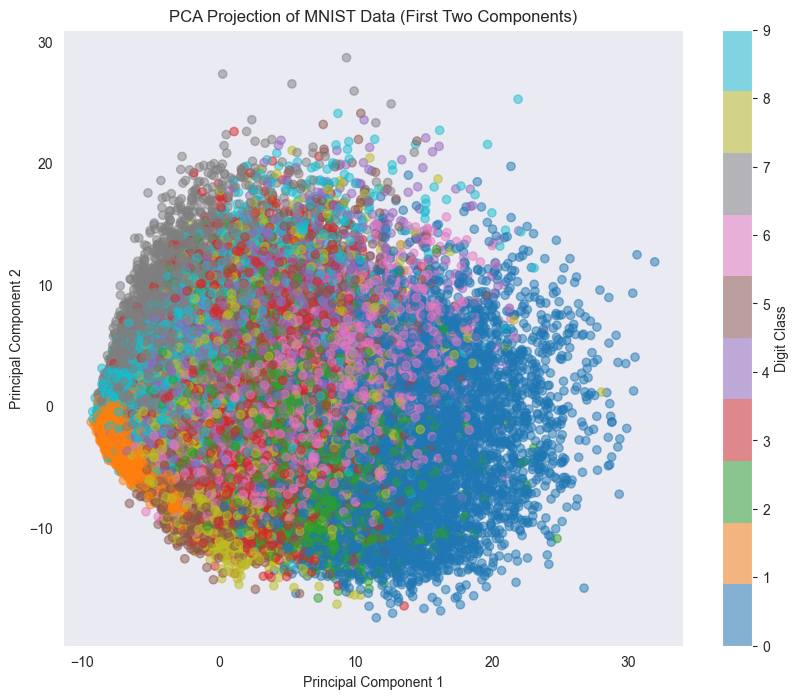

In [17]:
# Reduce dimensionality to 2 components for visualization
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Plot the first two principal components, colored by class
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y.astype(int), cmap='tab10', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of MNIST Data (First Two Components)')
plt.colorbar(scatter, label='Digit Class')
plt.grid()
plt.show()

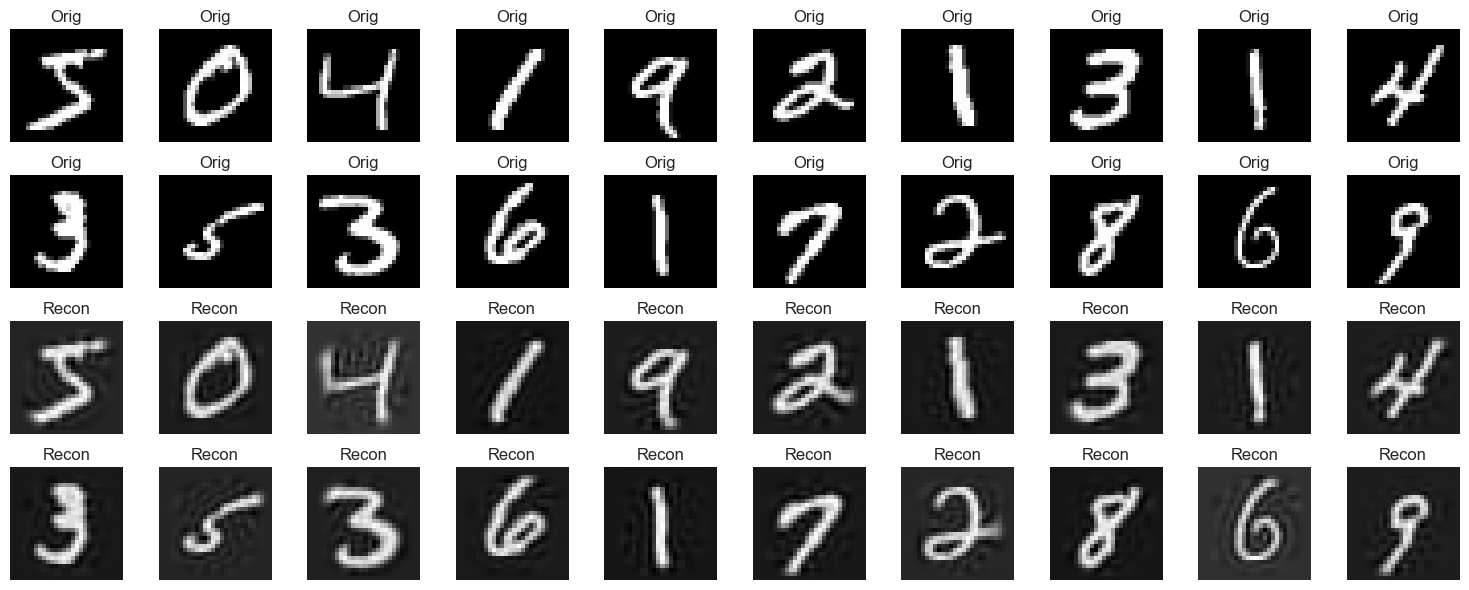

In [18]:
# Fit PCA to reduce to the number of components explaining 80% variance
pca_80 = PCA(n_components=n_components_80)
X_pca_80 = pca_80.fit_transform(X)

# Reconstruct the first 20 digits from the reduced representation
X_reconstructed = pca_80.inverse_transform(X_pca_80)

# Plot the first 20 original and reconstructed digits side by side
plt.figure(figsize=(15, 6))
for i in range(20):
    # Original digit
    plt.subplot(4, 10, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Orig')

    # Reconstructed digit
    plt.subplot(4, 10, i + 21)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Recon')

plt.tight_layout()
plt.show()

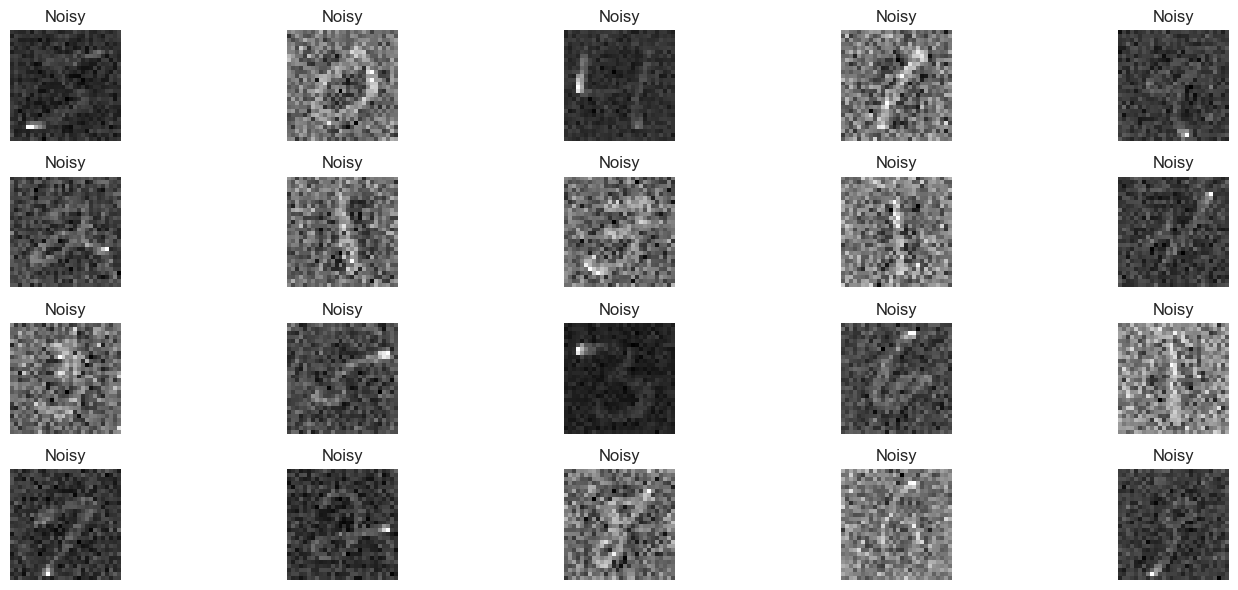

In [19]:
# Generate a noisy copy of the MNIST dataset
noise_factor = 1.0  # Adjust this value to control noise level
X_noisy = X_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_scaled.shape)

# Visualize the first 20 noisy digits
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Noisy')
plt.tight_layout()
plt.show()

Number of components needed to explain 90% of variance: 238


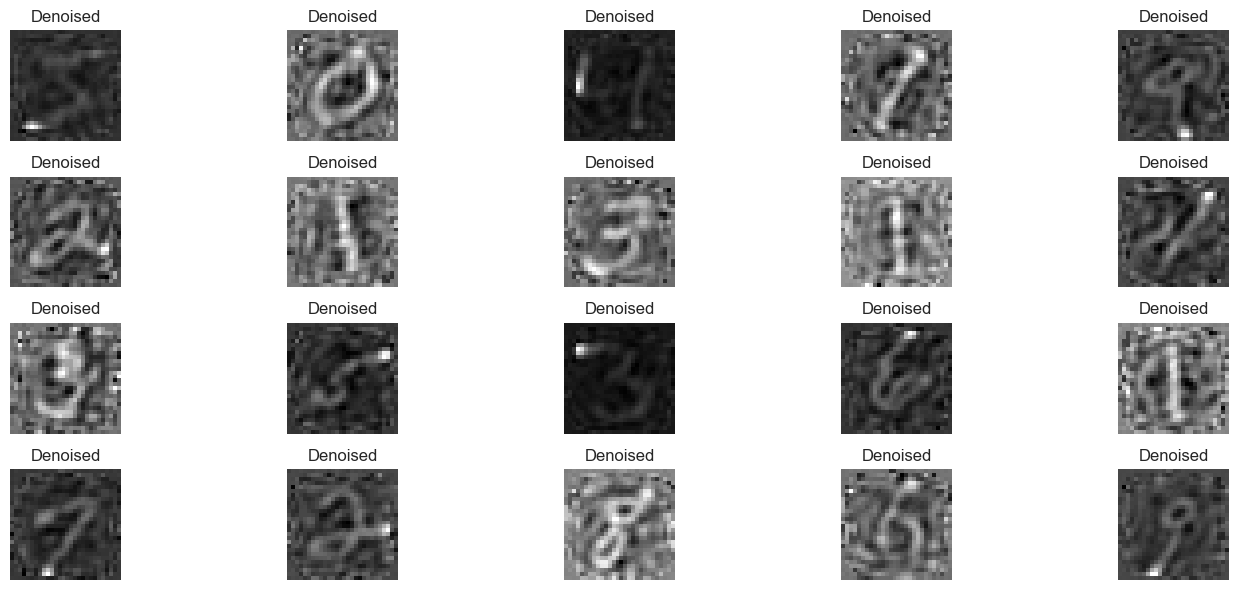

In [20]:
# Fit PCA to determine number of components that explain sufficient variance
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Choose the number of components to explain at least 90% variance (experiment to find the best)
threshold = 0.90  # You can adjust this value to 70%, 85%, 95%, etc.
n_components_denoise = np.argmax(cumulative_variance >= threshold) + 1
print(f'Number of components needed to explain {int(threshold * 100)}% of variance: {n_components_denoise}')

# Fit PCA to reduce dimensionality of the noisy data
pca_denoise = PCA(n_components=n_components_denoise)
X_noisy_pca = pca_denoise.fit_transform(X_noisy)

# Reconstruct the digits from the reduced representation
X_denoised = pca_denoise.inverse_transform(X_noisy_pca)

# Visualize the denoised digits
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_denoised[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Denoised')
plt.tight_layout()
plt.show()